In [1]:
import pandas as pd
import gffutils
import pybedtools
import re
import numpy as np

v19db_filename = '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'
v19db = gffutils.FeatureDB(v19db_filename)

folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'
exons_to_junctions = pd.read_csv('{}/exons_to_junctions_se.csv'.format(folder), index_col=0)
exons_to_junctions.head()

/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:784: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


,exon1,exon2,exon3,junction_exon12,junction_exon23,junction_exon13,event_id
0,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188908-100189399:-,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:10...
1,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188913-100189399:-,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:10...
2,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100189330-100189399:-,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:10...
3,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-,chr10:100191049-100193696:-,chr10:100190428-100190887:-,chr10:100190428-100193696:-,exon:chr10:100193697-100193848:-@exon:chr10:10...
4,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193697-100193848:-,chr10:100195172-100195391:-,chr10:100193849-100195028:-,chr10:100193849-100195391:-,exon:chr10:100195392-100195529:-@exon:chr10:10...


In [8]:
import itertools

best_tags = 'appris_principal', 'appris_candidate', 'CCDS', 'basic'

transcript_cols = ['isoform1_transcripts', 'isoform2_transcripts']

def get_attribute(features, attribute):
    try:
        for feature in features:
            try:
                yield feature[attribute]
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass
        
        
def get_feature_attribute_with_value(features, attribute, value):
    try:
        for feature in features:
            try:
                if value in feature[attribute]:
                    yield feature.id
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass
    
def get_feature_attribute_startswith_value(features, attribute, value):
    try:
        for feature in features:
            try:
                if any(map(lambda x: x.startswith(value), feature[attribute])):
                    yield feature.id
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass


def consolidate_junction_events(df, event_col='event_id', transcript_cols=['isoform1_transcripts', 'isoform2_transcripts']):
    if len(df) == 1:
        return 'only one', df[event_col].values[0]
#     print '\n---', name, df.shape, '---'
#     print '\t'.join(df[exon_cols].values[0])
    
    best_event = None
    
    df_isoforms = df[transcript_cols].applymap(lambda x: np.nan if len(x) == 0 else map(lambda y: v19db[y], x))
    df_isoforms = df_isoforms.dropna(how='all')
    
    if df_isoforms.empty:
#         print '-- random event:', df.loc[np.random.choice(df.index), event_col]
        return 'random,no gencode transcripts', df.loc[np.random.choice(df.index), event_col]
        
    if len(df_isoforms) == 1:
#         print '- one event with isoforms:', df.loc[df_isoforms.index, event_col]        
        return 'one event with gencode transcripts', df.loc[df_isoforms.index[0], event_col]
        
    df_tags = df_isoforms.applymap(
            lambda x: tuple(itertools.chain(*get_attribute(x, 'tag'))) if not isinstance(x, float) else x)
    df_tags = df_tags.applymap(lambda x: x if not isinstance(x, list) or len(x) > 0 else np.nan)
    df_tags = df_tags.dropna(how='all')
    if df_tags.empty:
#         print '- random df_isoforms:', df_isoforms.loc[np.random.choice(df_isoforms.index)]
        return 'random df_isoforms', df_isoforms.loc[np.random.choice(df_isoforms.index)]
        
#     print df_tags
    
    for tag in best_tags:
#         print tag
        df_this_tag = df_tags.applymap(lambda x: map(lambda y: y.startswith(tag), x) if isinstance(x, tuple) else False)
        
        # Which isoform has at least one true
        df_this_tag = df_this_tag.any(axis=1)
#         print df_this_tag
        if df_this_tag.any():
            best_index = np.random.choice(df_this_tag.index[df_this_tag])
#             print '- best isoform:', tag, best_index
#             print df.loc[best_index].event_id
            return 'best,{}'.format(tag), df.loc[best_index].event_id
    else:
        return 'random,no good tags', df.loc[np.random.choice(df.index), event_col]

#         isoform1_tag = list(get_feature_attribute_with_value(row.isoform1_transcripts, 'tag', tag))
#         isoform2_tag = list(get_feature_attribute_with_value(row.isoform2_transcripts, 'tag', tag))
#         print 'isoform1', tag, isoform1_tag,
#         print '\tother tags:', list(get_attribute(row.isoform1_transcripts, 'tag'))

#         print 'isoform2', tag, isoform2_tag,
#         print '\tother tags:', list(get_attribute(row.isoform2_transcripts, 'tag'))



## Skipped Exon (SE)

In [3]:
junction_cols = [x for x in exons_to_junctions if 'junction' in x]
exons_to_junctions.groupby(junction_cols).size().shape

(28034,)

In [4]:
splicing_feature_data = pd.read_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/splicing_feature_data.csv', index_col=0)
splicing_feature_data.head()

,gencode_id,ensembl_id,gene_name,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,exon2_divisible_by_3,intron12_length_summed,...,isoform2_molecular_weight,isoform_domain_effects,isoform1_pfam_accession,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,492,681,148,True,829,...,9467.0555,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,487,681,148,True,829,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,70,681,148,True,829,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,HPS1,152,161,100,2648,460,False,3108,...,14073.8461,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,ENSG00000107521.14,ENSG00000107521,HPS1,138,143,152,220,1180,False,1400,...,15151.2417,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
exons_feature_data = exons_to_junctions.join(splicing_feature_data, on='event_id', how='outer')

In [6]:
exons_feature_data.head()

,exon1,exon2,exon3,junction_exon12,junction_exon23,junction_exon13,event_id,gencode_id,ensembl_id,gene_name,...,isoform2_molecular_weight,isoform_domain_effects,isoform1_pfam_accession,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id
0,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188908-100189399:-,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,HPS1,...,9467.0555,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188913-100189399:-,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,HPS1,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100189330-100189399:-,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,HPS1,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-,chr10:100191049-100193696:-,chr10:100190428-100190887:-,chr10:100190428-100193696:-,exon:chr10:100193697-100193848:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,HPS1,...,14073.8461,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193697-100193848:-,chr10:100195172-100195391:-,chr10:100193849-100195028:-,chr10:100193849-100195391:-,exon:chr10:100195392-100195529:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,HPS1,...,15151.2417,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
exons_feature_data.shape

(58842, 57)

In [8]:
from poshsplice.region import Region

In [9]:
ns = 1, 2, 3

for n in ns: 
    exons_feature_data['exon{}_region'.format(n)] = exons_feature_data['exon{}'.format(n)].map(Region)
    exons_feature_data['exon{}_length'.format(n)] = exons_feature_data['exon{}_region'.format(n)].map(len)

In [23]:
translation_cols = [x for x in splicing_feature_data.columns if 'translation' in x]



In [24]:
%pdb

Automatic pdb calling has been turned ON


In [95]:
shared_junctions = exons_feature_data.groupby(junction_cols).size()
print 'unique:', (shared_junctions == 1).sum()
shared_junctions = shared_junctions[shared_junctions > 1]
print 'shared:', shared_junctions.shape[0]
shared_junctions.head()

unique: 14876
shared: 13158


junction_exon12              junction_exon23              junction_exon13            
chr10:100189647-100190327:-  chr10:100189400-100189547:-  chr10:100189400-100190327:-    3
chr10:100195172-100195391:-  chr10:100193849-100195028:-  chr10:100193849-100195391:-    2
chr10:101507148-101510125:+  chr10:101510154-101514285:+  chr10:101507148-101514285:+    2
chr10:101507148-101514285:+  chr10:101514392-101515381:+  chr10:101507148-101515381:+    2
chr10:102258562-102258916:-  chr10:102257965-102258461:-  chr10:102257965-102258916:-    2
dtype: int64

In [66]:
shared_junctions[np.random.choice(shared_junctions.index, size=10)]

junction_exon12             junction_exon23             junction_exon13           
chr19:39924210-39924304:-   chr19:39924059-39924157:-   chr19:39924059-39924304:-     5
chr6:46636531-46638862:+    chr6:46638966-46644383:+    chr6:46636531-46644383:+      3
chr16:3361949-3362676:+     chr16:3362769-3367189:+     chr16:3361949-3367189:+       4
chr3:57232521-57233789:-    chr3:57232324-57232418:-    chr3:57232324-57233789:-      2
chr1:161182271-161182381:+  chr1:161182445-161183169:+  chr1:161182271-161183169:+    2
chr17:18761575-18768781:+   chr17:18768878-18769114:+   chr17:18761575-18769114:+     2
chr16:75600806-75601934:+   chr16:75602108-75611176:+   chr16:75600806-75611176:+     2
chr12:50135395-50135739:+   chr12:50136064-50146246:+   chr12:50135395-50146246:+     4
chr5:133710155-133716409:+  chr5:133716500-133725915:+  chr5:133710155-133725915:+    6
chr19:9724780-9727720:-     chr19:9722013-9724696:-     chr19:9722013-9727720:-       8
dtype: int64

In [104]:
import itertools


size = 10
index = shared_junctions[np.random.choice(shared_junctions.index, size=size)].index

exons_feature_data_subset = exons_to_junctions.set_index(junction_cols).loc[index].reset_index()
print exons_feature_data_subset.groupby(junction_cols).size()

junction_exon12             junction_exon23             junction_exon13           
chr10:89067818-89086386:-   chr10:89048253-89067713:-   chr10:89048253-89086386:-     3
chr15:60666882-60674540:-   chr15:60656723-60666817:-   chr15:60656723-60674540:-     2
chr17:38802100-38804024:-   chr17:38798812-38802047:-   chr17:38798812-38804024:-     2
chr17:5326150-5329555:+     chr17:5329620-5331390:+     chr17:5326150-5331390:+       5
chr17:74553940-74554455:+   chr17:74554683-74557369:+   chr17:74553940-74557369:+     2
chr2:20526147-20527070:-    chr2:20518407-20526021:-    chr2:20518407-20527070:-      2
chr3:93781983-93782655:+    chr3:93782969-93783280:+    chr3:93781983-93783280:+      2
chr4:24531394-24534486:-    chr4:24529665-24531223:-    chr4:24529665-24534486:-      4
chr7:144345973-144380001:-  chr7:144320355-144345899:-  chr7:144320355-144380001:-    2
chrX:102631542-102631955:+  chrX:102632035-102632390:+  chrX:102631542-102632390:+    2
dtype: int64


In [105]:
translation_cols = [x for x in splicing_feature_data if 'translation' in x]
translation_cols

['isoform1_translation', 'isoform2_translation']

In [106]:
pd.options.display.max_colwidth = 100

In [107]:
exon_cols = ['exon1', 'exon2', 'exon3']

In [111]:
range(3)

[0, 1, 2]

In [ ]:
exons_feature_data_subset['isoform1']

In [181]:


ns = 1, 2, 3

isoform1_exons = 'exon1', 'exon3'
isoform2_exons = 'exon1',  'exon2', 'exon3'

def get_attribute(features, attribute):
    for feature in features:
        try:
            yield feature[attribute]
        except KeyError:
            pass
        
def get_feature_with_attribute_value(features, attribute, value):
    for feature in features:
        try:
            if value in feature[attribute]:
                yield feature.id
        except KeyError:
            pass

def get_isoform_transcripts(row, exons, exclude_exons=None):
    transcripts = map(lambda x: set(v19db.parents(v19db[row[x]], featuretype='transcript')), exons)
    transcripts = set.intersection(*transcripts)

    if exclude_exons is not None:
        exclude_exons = [exclude_exons] if isinstance(exclude_exons, str) else exclude_exons
        exclude_transcripts = map(lambda x: set(v19db.parents(v19db[row[x]], featuretype='transcript')), exclude_exons)
        transcripts = transcripts.difference(set.intersection(*exclude_transcripts))
    return transcripts

best_tags = 'appris_principal', 'appris_candidate', 'CCDS', 'basic'

for name, df in exons_feature_data_subset.groupby(junction_cols):
    if len(df) == 1:
        continue
    print '\n ---', name, df.shape, '---'
    print '\t'.join(df[exon_cols].values[0])
    
    
    for i, row in df.iterrows():
        print 
        print splicing_feature_data.loc[row.event_id, translation_cols]
        
        isoform1_transcripts = get_isoform_transcripts(row, isoform1_exons, exclude_exons=('exon2'))
        isoform2_transcripts = get_isoform_transcripts(row, isoform2_exons)
#         print isoform1_transcripts

#         isoform1_tags = list(get_attribute(isoform1_transcripts, 'tag'))
#         isoform2_tags = list(get_attribute(isoform2_transcripts, 'tag'))

#         isoform1_level = list(get_attribute(isoform1_transcripts, 'level'))
#         isoform2_level = list(get_attribute(isoform2_transcripts, 'level'))
        for tag in best_tags:
            isoform1_tag = list(get_feature_with_attribute_value(isoform1_transcripts, 'tag', tag))
            isoform2_tag = list(get_feature_with_attribute_value(isoform2_transcripts, 'tag', tag))
            print 'isoform1', tag, isoform1_tag
            print 'isoform2', tag, isoform2_tag
        
        
#         for transcript in isoform1_transcripts:
#             print '\t', i, 'isoform1', transcript.id, 
#             try:
#                 print transcript['tag'], 'appris_principal' in transcript['tag']
#             except KeyError:
#                 print
            
#         for transcript in isoform2_transcripts:
#             print '\t\t', i, 'isoform2', transcript.id, 
#             try:
#                 print transcript['tag'], 'appris_principal' in transcript['tag']
#             except KeyError:
#                 print



 --- ('chr11:66411612-66412104:+', 'chr11:66412215-66413497:+', 'chr11:66411612-66413497:+') (5, 62) ---
exon:chr11:66411221-66411611:+	exon:chr11:66412105-66412214:+	exon:chr11:66413498-66413910:+

isoform1_translation    NaN
isoform2_translation    NaN
Name: exon:chr11:66411221-66411611:+@exon:chr11:66412105-66412214:+@exon:chr11:66413498-66413910:+, dtype: object
isoform1 appris_principal []
isoform2 appris_principal []
isoform1 appris_candidate []
isoform2 appris_candidate []
isoform1 CCDS []
isoform2 CCDS []
isoform1 basic []
isoform2 basic []

isoform1_translation    NaN
isoform2_translation    NaN
Name: exon:chr11:66411221-66411611:+@exon:chr11:66412105-66412214:+@exon:chr11:66413498-66413923:+, dtype: object
isoform1 appris_principal []
isoform2 appris_principal []
isoform1 appris_candidate []
isoform2 appris_candidate []
isoform1 CCDS []
isoform2 CCDS []
isoform1 basic []
isoform2 basic []

isoform1_translation    NaN
isoform2_translation    NaN
Name: exon:chr11:66411221-6641

In [127]:
%pdb

Automatic pdb calling has been turned ON


In [138]:
%%timeit
exons_feature_data_subset.apply(lambda row: map(lambda x: x.id, get_isoform_transcripts(row, exons=isoform1_exons, exclude_exons='exon2')),
                                axis=1)

1 loops, best of 3: 318 ms per loop


In [ ]:
%%time
exons_feature_data['isoform1_transcripts'] = exons_feature_data.apply(
    lambda row: map(lambda x: x.id, get_isoform_transcripts(row, exons=isoform1_exons, exclude_exons='exon2')), axis=1)

CPU times: user 3min 37s, sys: 1min 15s, total: 4min 53s
Wall time: 14min 5s


In [ ]:
%%time
exons_feature_data['isoform2_transcripts'] = exons_feature_data.apply(
    lambda row: map(lambda x: x.id, get_isoform_transcripts(row, exons=isoform2_exons)), axis=1)

junction_exon12             junction_exon23             junction_exon13           
chr11:66411612-66412104:+   chr11:66412215-66413497:+   chr11:66411612-66413497:+     5
chr14:93171053-93172827:-   chr14:93170707-93170984:-   chr14:93170707-93172827:-     6
chr15:50581863-50592985:-   chr15:50578381-50581679:-   chr15:50578381-50592985:-     4
chr1:113366377-113368134:-  chr1:113363161-113366274:-  chr1:113363161-113368134:-    2
chr21:30380445-30380715:-   chr21:30378973-30380081:-   chr21:30378973-30380715:-     2
chr5:162868971-162869050:+  chr5:162869150-162869379:+  chr5:162868971-162869379:+    2
chr6:64346056-64389900:+    chr6:64390063-64394029:+    chr6:64346056-64394029:+      3
chr8:141745555-141749116:-  chr8:141716305-141745349:-  chr8:141716305-141749116:-    2
chr9:116172009-116172334:-  chr9:116171264-116171889:-  chr9:116171264-116172334:-    2
chr9:140470855-140473076:-  chr9:140470620-140470760:-  chr9:140470620-140473076:-    3
dtype: int64


In [226]:
import itertools


size = 10
index = shared_junctions[np.random.choice(shared_junctions.index, size=size)].index

exons_feature_data_subset = exons_feature_data.set_index(junction_cols).loc[index].reset_index()
print exons_feature_data_subset.groupby(junction_cols).size()

junction_exon12              junction_exon23              junction_exon13            
chr12:121013492-121013594:+  chr12:121013754-121014392:+  chr12:121013492-121014392:+    6
chr14:69922584-69925079:+    chr14:69925447-69928413:+    chr14:69922584-69928413:+      2
chr15:63335143-63336225:+    chr15:63336352-63349183:+    chr15:63335143-63349183:+      2
chr16:2329132-2331027:-      chr16:2328460-2328943:-      chr16:2328460-2331027:-        2
chr22:21831054-21832078:-    chr22:21830450-21830932:-    chr22:21830450-21832078:-      2
chr5:131607160-131607483:+   chr5:131607602-131607717:+   chr5:131607160-131607717:+     3
chr5:68666999-68667983:+     chr5:68668045-68669656:+     chr5:68666999-68669656:+       2
chr7:30538555-30544184:-     chr7:30536852-30538418:-     chr7:30536852-30544184:-       7
chr8:17532762-17541836:-     chr8:17513575-17532694:-     chr8:17513575-17541836:-       4
chrX:102072011-102081896:+   chrX:102082073-102094728:+   chrX:102072011-102094728:+     2
dtyp

In [229]:
import itertools

best_tags = 'appris_principal', 'appris_candidate', 'CCDS', 'basic'

transcript_cols = ['isoform1_transcripts', 'isoform2_transcripts']

def get_attribute(features, attribute):
    try:
        for feature in features:
            try:
                yield feature[attribute]
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass
        
        
def get_feature_attribute_with_value(features, attribute, value):
    try:
        for feature in features:
            try:
                if value in feature[attribute]:
                    yield feature.id
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass
    
def get_feature_attribute_startswith_value(features, attribute, value):
    try:
        for feature in features:
            try:
                if any(map(lambda x: x.startswith(value), feature[attribute])):
                    yield feature.id
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass

for name, df in exons_feature_data_subset.groupby(junction_cols):
    if len(df) == 1:
        continue
    print '\n---', name, df.shape, '---'
    print '\t'.join(df[exon_cols].values[0])
    
    best_event = None
    
    df_isoforms = df[transcript_cols].applymap(lambda x: np.nan if len(x) == 0 else map(lambda y: v19db[y], x))
    df_isoforms = df_isoforms.dropna(how='all')
    
    if df_isoforms.empty:
        print '-- random event:', df.loc[np.random.choice(df.index)].event_id
        continue
    if len(df_isoforms) == 1:
        print '- one event with isoforms:', df.loc[df_isoforms.index].event_id
        continue
    df_tags = df_isoforms.applymap(
            lambda x: tuple(itertools.chain(*get_attribute(x, 'tag'))) if not isinstance(x, float) else x)
    df_tags = df_tags.applymap(lambda x: x if not isinstance(x, list) or len(x) > 0 else np.nan)
    df_tags = df_tags.dropna(how='all')
    if df_tags.empty:
        print '- random df_isoforms:', df_isoforms.loc[np.random.choice(df_isoforms.index)]
        continue
    print df_tags
    
    for tag in best_tags:
        print tag
        df_this_tag = df_tags.applymap(lambda x: tag in x if isinstance(x, tuple) else False)
        
        # Which isoform has at least one true
        df_this_tag = df_this_tag.any(axis=1)
        print df_this_tag
        if df_this_tag.any():
            best_index = np.random.choice(df_this_tag.index[df_this_tag])
            print '- best isoform:', tag, best_index
            print df.loc[best_index].event_id
            break

#         isoform1_tag = list(get_feature_attribute_with_value(row.isoform1_transcripts, 'tag', tag))
#         isoform2_tag = list(get_feature_attribute_with_value(row.isoform2_transcripts, 'tag', tag))
#         print 'isoform1', tag, isoform1_tag,
#         print '\tother tags:', list(get_attribute(row.isoform1_transcripts, 'tag'))

#         print 'isoform2', tag, isoform2_tag,
#         print '\tother tags:', list(get_attribute(row.isoform2_transcripts, 'tag'))




--- ('chr12:121013492-121013594:+', 'chr12:121013754-121014392:+', 'chr12:121013492-121014392:+') (6, 62) ---
exon:chr12:121013434-121013491:+	exon:chr12:121013595-121013753:+	exon:chr12:121014393-121014681:+
    isoform1_transcripts  \
14                   NaN   
15                   NaN   
16                   NaN   
18                   NaN   

                                              isoform2_transcripts  
14                                                              ()  
15  (basic, appris_candidate_longest, mRNA_start_NF, cds_start_NF)  
16                                   (mRNA_start_NF, cds_start_NF)  
18                                 (basic, appris_candidate, CCDS)  
appris_principal
14    False
15    False
16    False
18    False
dtype: bool
appris_candidate
14    False
15    False
16    False
18     True
dtype: bool
- best isoform: appris_candidate 18
exon:chr12:121013434-121013491:+@exon:chr12:121013595-121013753:+@exon:chr12:121014393-121015397:+

--- ('chr14:69

In [257]:
import itertools

best_tags = 'appris_principal', 'appris_candidate', 'CCDS', 'basic'

transcript_cols = ['isoform1_transcripts', 'isoform2_transcripts']

def get_attribute(features, attribute):
    try:
        for feature in features:
            try:
                yield feature[attribute]
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass
        
        
def get_feature_attribute_with_value(features, attribute, value):
    try:
        for feature in features:
            try:
                if value in feature[attribute]:
                    yield feature.id
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass
    
def get_feature_attribute_startswith_value(features, attribute, value):
    try:
        for feature in features:
            try:
                if any(map(lambda x: x.startswith(value), feature[attribute])):
                    yield feature.id
            except KeyError:
                pass
    except TypeError:
        # The features aren't iterable
        pass


def consolidate_junction_events(df, event_col='event_id', transcript_cols=['isoform1_transcripts', 'isoform2_transcripts']):
    if len(df) == 1:
        return 'only one', df[event_col].values[0]
#     print '\n---', name, df.shape, '---'
#     print '\t'.join(df[exon_cols].values[0])
    
    best_event = None
    
    df_isoforms = df[transcript_cols].applymap(lambda x: np.nan if len(x) == 0 else map(lambda y: v19db[y], x))
    df_isoforms = df_isoforms.dropna(how='all')
    
    if df_isoforms.empty:
#         print '-- random event:', df.loc[np.random.choice(df.index), event_col]
        return 'random,no gencode transcripts', df.loc[np.random.choice(df.index), event_col]
        
    if len(df_isoforms) == 1:
#         print '- one event with isoforms:', df.loc[df_isoforms.index, event_col]        
        return 'one event with gencode transcripts', df.loc[df_isoforms.index[0], event_col]
        
    df_tags = df_isoforms.applymap(
            lambda x: tuple(itertools.chain(*get_attribute(x, 'tag'))) if not isinstance(x, float) else x)
    df_tags = df_tags.applymap(lambda x: x if not isinstance(x, list) or len(x) > 0 else np.nan)
    df_tags = df_tags.dropna(how='all')
    if df_tags.empty:
#         print '- random df_isoforms:', df_isoforms.loc[np.random.choice(df_isoforms.index)]
        return 'random df_isoforms', df_isoforms.loc[np.random.choice(df_isoforms.index)]
        
#     print df_tags
    
    for tag in best_tags:
#         print tag
        df_this_tag = df_tags.applymap(lambda x: map(lambda y: y.startswith(tag), x) if isinstance(x, tuple) else False)
        
        # Which isoform has at least one true
        df_this_tag = df_this_tag.any(axis=1)
#         print df_this_tag
        if df_this_tag.any():
            best_index = np.random.choice(df_this_tag.index[df_this_tag])
#             print '- best isoform:', tag, best_index
#             print df.loc[best_index].event_id
            return 'best,{}'.format(tag), df.loc[best_index].event_id
    else:
        return 'random,no good tags', df.loc[np.random.choice(df.index), event_col]

#         isoform1_tag = list(get_feature_attribute_with_value(row.isoform1_transcripts, 'tag', tag))
#         isoform2_tag = list(get_feature_attribute_with_value(row.isoform2_transcripts, 'tag', tag))
#         print 'isoform1', tag, isoform1_tag,
#         print '\tother tags:', list(get_attribute(row.isoform1_transcripts, 'tag'))

#         print 'isoform2', tag, isoform2_tag,
#         print '\tother tags:', list(get_attribute(row.isoform2_transcripts, 'tag'))



In [258]:
%time consolidated_junctions = exons_feature_data.groupby(junction_cols).apply(consolidate_junction_events, event_col='event_id')
consolidated_junctions.head()

CPU times: user 1min 49s, sys: 9.97 s, total: 1min 59s
Wall time: 3min 29s


junction_exon12              junction_exon23              junction_exon13            
chr10:100189647-100190327:-  chr10:100189400-100189547:-  chr10:100189400-100190327:-    (best,appris_principal, exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:c...
chr10:100191049-100193696:-  chr10:100190428-100190887:-  chr10:100190428-100193696:-    (only one, exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:10019032...
chr10:100195172-100195391:-  chr10:100193849-100195028:-  chr10:100193849-100195391:-    (best,appris_principal, exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:c...
chr10:101163632-101165512:-  chr10:101163392-101163480:-  chr10:101163392-101165512:-    (only one, exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:10116322...
chr10:101419346-101419618:+  chr10:101419722-101421202:+  chr10:101419346-101421202:+    (only one, exon:chr10:101419263-101419345:+@exon:chr10:101419619-1014

In [266]:
consolidated_df = consolidated_junctions.reset_index()
consolidated_df['criteria_full'] = consolidated_df[0].map(lambda x: x[0])
consolidated_df['event_id'] = consolidated_df[0].map(lambda x: x[1])
consolidated_df['criteria'] = consolidated_df[0].map(lambda x: x[0].split(',')[0])
consolidated_df['criteria_additional'] = consolidated_df['criteria_full'].map(
    lambda x: x.split(',')[1] if len(x.split(',')) > 1 else np.nan)
consolidated_df = consolidated_df.drop(0, axis=1)
consolidated_df.head()

,junction_exon12,junction_exon23,junction_exon13,0,criteria_full,event_id,criteria,criteria_additional
0,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,"(best,appris_principal, exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:c...","best,appris_principal",exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal
1,chr10:100191049-100193696:-,chr10:100190428-100190887:-,chr10:100190428-100193696:-,"(only one, exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:10019032...",only one,exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN
2,chr10:100195172-100195391:-,chr10:100193849-100195028:-,chr10:100193849-100195391:-,"(best,appris_principal, exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:c...","best,appris_principal",exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal
3,chr10:101163632-101165512:-,chr10:101163392-101163480:-,chr10:101163392-101165512:-,"(only one, exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:10116322...",only one,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN
4,chr10:101419346-101419618:+,chr10:101419722-101421202:+,chr10:101419346-101421202:+,"(only one, exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:10142120...",only one,exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN


In [299]:
consolidated_df = consolidated_df.drop(0, axis=1)
consolidated_df.head()

,junction_exon12,junction_exon23,junction_exon13,criteria_full,event_id,criteria,criteria_additional
0,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,"best,appris_principal",exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal
1,chr10:100191049-100193696:-,chr10:100190428-100190887:-,chr10:100190428-100193696:-,only one,exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN
2,chr10:100195172-100195391:-,chr10:100193849-100195028:-,chr10:100193849-100195391:-,"best,appris_principal",exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal
3,chr10:101163632-101165512:-,chr10:101163392-101163480:-,chr10:101163392-101165512:-,only one,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN
4,chr10:101419346-101419618:+,chr10:101419722-101421202:+,chr10:101419346-101421202:+,only one,exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN


In [16]:
consolidated_df.shape

(5659, 8)

In [300]:
consolidated_df.to_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/skipped_exon_consolidated_junctions.csv', index=False)

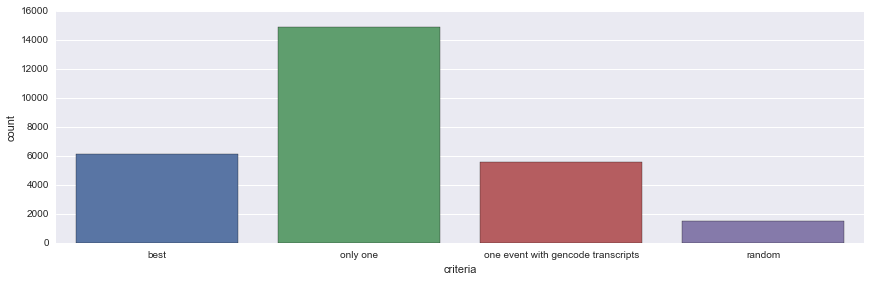

In [269]:
import seaborn as sns
%matplotlib inline


sns.factorplot(x='criteria', data=consolidated_df, kind='count', aspect=3)

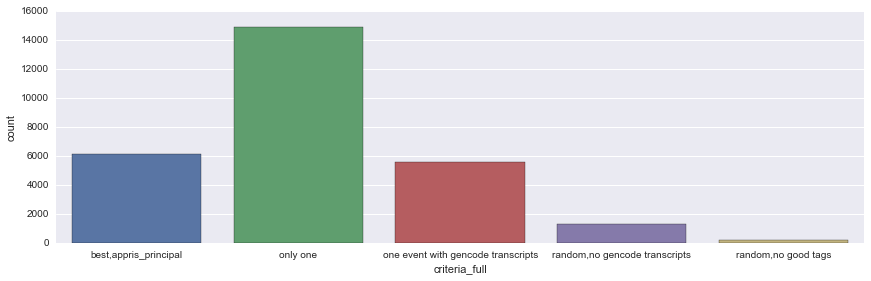

In [270]:
import seaborn as sns
%matplotlib inline


sns.factorplot(x='criteria_full', data=consolidated_df, kind='count', aspect=3)

In [276]:
exon_transcripts = exons_feature_data.set_index('event_id')[transcript_cols]
exon_transcripts.head()

,isoform1_transcripts,isoform2_transcripts
event_id,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,[],[ENST00000338546.5]
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,[ENST00000414009.1],[]
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,"[ENST00000359632.3, ENST00000498219.1, ENST00000470095.1, ENST00000478087.1, ENST00000467246.1]","[ENST00000361490.4, ENST00000325103.6]"
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,[ENST00000470095.1],"[ENST00000478087.1, ENST00000467246.1]"
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,[],[ENST00000467246.1]


In [278]:
no_good_tags = consolidated_df.loc[consolidated_df.criteria_full == 'random,no good tags'].event_id
exon_transcripts.loc[no_good_tags]

,isoform1_transcripts,isoform2_transcripts
event_id,,
exon:chr10:97893340-97893405:+@exon:chr10:97894927-97895046:+@exon:chr10:97915083-97915155:+,[ENST00000488700.1],[]
exon:chr10:97893340-97893405:+@exon:chr10:97911173-97911323:+@exon:chr10:97915083-97915133:+,[],[ENST00000316045.5]
exon:chr10:97893340-97893405:+@exon:chr10:97911173-97911323:+@exon:chr10:97915681-97915776:+,[],[ENST00000488700.1]
exon:chr10:97893340-97893405:+@exon:chr10:97915083-97915133:+@exon:chr10:97915681-97915804:+,[],[ENST00000316045.5]
exon:chr10:97893340-97893405:+@exon:chr10:97915083-97915155:+@exon:chr10:97915681-97915804:+,[ENST00000316045.5],[]
exon:chr11:134890-134947:-@exon:chr11:134564-134796:-@exon:chr11:133573-133778:-,[],[ENST00000607448.1]
exon:chr11:138047-138111:-@exon:chr11:134890-134947:-@exon:chr11:133573-133778:-,[],[ENST00000607448.1]
exon:chr11:2017309-2017421:-@exon:chr11:2017106-2017228:-@exon:chr11:2016440-2017024:-,[],[]
exon:chr11:62620547-62620587:-@exon:chr11:62620283-62620311:-@exon:chr11:62619463-62620153:-,[],[ENST00000537869.1]


In [296]:
exon_transcript_features_tags = exon_transcripts.loc[no_good_tags].applymap(
    lambda x: map(lambda y: v19db[y], x) if len(x) > 0 else np.nan)

In [297]:
attribute = 'transcript_type'

exon_transcript_features_tags.applymap(
    lambda x: list(get_attribute(x, attribute=attribute)) 
    if len(list(get_attribute(x, attribute=attribute))) > 0 else np.nan).dropna(how='all')

,isoform1_transcripts,isoform2_transcripts
event_id,,
exon:chr10:97893340-97893405:+@exon:chr10:97894927-97895046:+@exon:chr10:97915083-97915155:+,[[processed_transcript]],NaN
exon:chr10:97893340-97893405:+@exon:chr10:97911173-97911323:+@exon:chr10:97915083-97915133:+,NaN,[[processed_transcript]]
exon:chr10:97893340-97893405:+@exon:chr10:97911173-97911323:+@exon:chr10:97915681-97915776:+,NaN,[[processed_transcript]]
exon:chr10:97893340-97893405:+@exon:chr10:97915083-97915133:+@exon:chr10:97915681-97915804:+,NaN,[[processed_transcript]]
exon:chr10:97893340-97893405:+@exon:chr10:97915083-97915155:+@exon:chr10:97915681-97915804:+,[[processed_transcript]],NaN
exon:chr11:134890-134947:-@exon:chr11:134564-134796:-@exon:chr11:133573-133778:-,NaN,[[lincRNA]]
exon:chr11:138047-138111:-@exon:chr11:134890-134947:-@exon:chr11:133573-133778:-,NaN,[[lincRNA]]
exon:chr11:62620547-62620587:-@exon:chr11:62620283-62620311:-@exon:chr11:62619463-62620153:-,NaN,[[lincRNA]]
exon:chr11:67570473-67570535:-@exon:chr11:67564155-67564304:-@exon:chr11:67559238-67560764:-,NaN,[[processed_transcript]]


## MXE

In [3]:
exons_to_junctions = pd.read_csv('{}/exons_to_junctions_mxe.csv'.format(folder), index_col=0)
print exons_to_junctions.shape
exons_to_junctions.head()

(17748, 9)


,exon1,exon2,exon3,exon4,junction13,junction34,junction12,junction24,event_id
0,exon:chr10:102003455-102003529:-,exon:chr10:101997779-101997988:-,exon:chr10:101996607-101996726:-,exon:chr10:101995424-101995521:-,chr10:101996727-102003454:-,chr10:101995522-101996606:-,chr10:101997989-102003454:-,chr10:101995522-101997778:-,exon:chr10:102003455-102003529:-@exon:chr10:10...
1,exon:chr10:102003455-102003534:-,exon:chr10:101997779-101997988:-,exon:chr10:101996607-101996726:-,exon:chr10:101995424-101995521:-,chr10:101996727-102003454:-,chr10:101995522-101996606:-,chr10:101997989-102003454:-,chr10:101995522-101997778:-,exon:chr10:102003455-102003534:-@exon:chr10:10...
2,exon:chr10:102013178-102013296:-,exon:chr10:102010005-102010089:-,exon:chr10:102003455-102003534:-,exon:chr10:101997779-101997988:-,chr10:102003535-102013177:-,chr10:101997989-102003454:-,chr10:102010090-102013177:-,chr10:101997989-102010004:-,exon:chr10:102013178-102013296:-@exon:chr10:10...
3,exon:chr10:102013178-102014376:-,exon:chr10:102010005-102010089:-,exon:chr10:102003455-102003534:-,exon:chr10:101997779-101997988:-,chr10:102003535-102013177:-,chr10:101997989-102003454:-,chr10:102010090-102013177:-,chr10:101997989-102010004:-,exon:chr10:102013178-102014376:-@exon:chr10:10...
4,exon:chr10:102020723-102020785:-,exon:chr10:102019975-102020076:-,exon:chr10:102016019-102016233:-,exon:chr10:102013178-102013296:-,chr10:102016234-102020722:-,chr10:102013297-102016018:-,chr10:102020077-102020722:-,chr10:102013297-102019974:-,exon:chr10:102020723-102020785:-@exon:chr10:10...


### Add isoform transcripts

In [9]:
%%time

isoform1_exons = 'exon1', 'exon3', 'exon4'
isoform2_exons = 'exon1', 'exon2', 'exon4'


exons_to_junctions['isoform1_transcripts'] = exons_to_junctions.apply(
    lambda row: map(lambda x: x.id, get_isoform_transcripts(row, exons=isoform1_exons, exclude_exons='exon2')), axis=1)
exons_to_junctions['isoform2_transcripts'] = exons_to_junctions.apply(
    lambda row: map(lambda x: x.id, get_isoform_transcripts(row, exons=isoform2_exons, exclude_exons='exon3')), axis=1)

In [10]:
junction_cols = ['junction13', 'junction34', 'junction12', 'junction24']

In [11]:
%time consolidated_junctions = exons_to_junctions.groupby(junction_cols).apply(consolidate_junction_events, event_col='event_id')
consolidated_junctions.head()

CPU times: user 18.2 s, sys: 1.31 s, total: 19.6 s
Wall time: 37.7 s


junction13                   junction34                   junction12                   junction24                 
chr10:101996727-102003454:-  chr10:101995522-101996606:-  chr10:101997989-102003454:-  chr10:101995522-101997778:-    (one event with gencode transcripts, exon:chr1...
chr10:102003535-102013177:-  chr10:101997989-102003454:-  chr10:102010090-102013177:-  chr10:101997989-102010004:-    (one event with gencode transcripts, exon:chr1...
chr10:102016234-102020722:-  chr10:102013297-102016018:-  chr10:102020077-102020722:-  chr10:102013297-102019974:-    (random,no good tags, exon:chr10:102020723-102...
chr10:102016234-102021735:-  chr10:102013297-102016018:-  chr10:102020786-102021735:-  chr10:102013297-102020722:-    (only one, exon:chr10:102021736-102021820:-@ex...
                                                          chr10:102020802-102021735:-  chr10:102013297-102020722:-    (only one, exon:chr10:102021736-102021820:-@ex...
dtype: object

In [12]:
consolidated_df = consolidated_junctions.reset_index()
consolidated_df['criteria_full'] = consolidated_df[0].map(lambda x: x[0])
consolidated_df['event_id'] = consolidated_df[0].map(lambda x: x[1])
consolidated_df['criteria'] = consolidated_df[0].map(lambda x: x[0].split(',')[0])
consolidated_df['criteria_additional'] = consolidated_df['criteria_full'].map(
    lambda x: x.split(',')[1] if len(x.split(',')) > 1 else np.nan)
consolidated_df = consolidated_df.drop(0, axis=1)
consolidated_df.head()

,junction13,junction34,junction12,junction24,criteria_full,event_id,criteria,criteria_additional
0,chr10:101996727-102003454:-,chr10:101995522-101996606:-,chr10:101997989-102003454:-,chr10:101995522-101997778:-,one event with gencode transcripts,exon:chr10:102003455-102003534:-@exon:chr10:10...,one event with gencode transcripts,NaN
1,chr10:102003535-102013177:-,chr10:101997989-102003454:-,chr10:102010090-102013177:-,chr10:101997989-102010004:-,one event with gencode transcripts,exon:chr10:102013178-102013296:-@exon:chr10:10...,one event with gencode transcripts,NaN
2,chr10:102016234-102020722:-,chr10:102013297-102016018:-,chr10:102020077-102020722:-,chr10:102013297-102019974:-,"random,no good tags",exon:chr10:102020723-102020801:-@exon:chr10:10...,random,no good tags
3,chr10:102016234-102021735:-,chr10:102013297-102016018:-,chr10:102020786-102021735:-,chr10:102013297-102020722:-,only one,exon:chr10:102021736-102021820:-@exon:chr10:10...,only one,NaN
4,chr10:102016234-102021735:-,chr10:102013297-102016018:-,chr10:102020802-102021735:-,chr10:102013297-102020722:-,only one,exon:chr10:102021736-102021820:-@exon:chr10:10...,only one,NaN


In [15]:
consolidated_df.to_csv('{}/mutually_exclusive_exon_consolidated_events.csv'.format(folder), index=False)

In [17]:
consolidated_df.shape

(5659, 8)

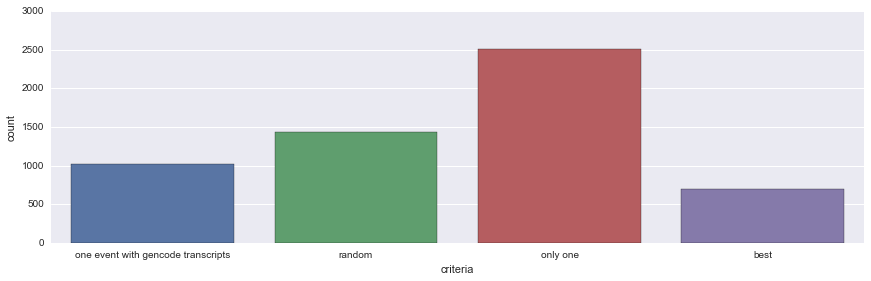

In [13]:
import seaborn as sns
%matplotlib inline


sns.factorplot(x='criteria', data=consolidated_df, kind='count', aspect=3)

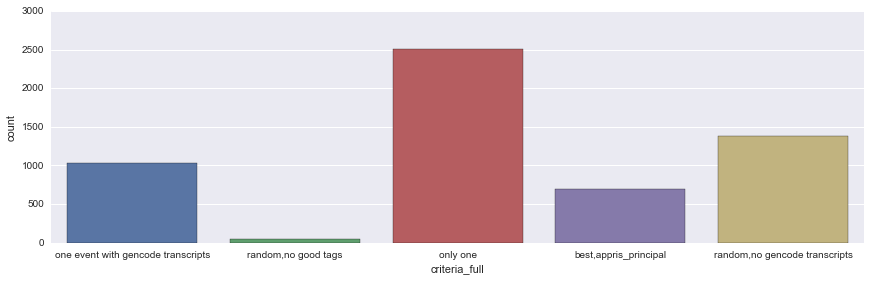

In [14]:
import seaborn as sns
%matplotlib inline


sns.factorplot(x='criteria_full', data=consolidated_df, kind='count', aspect=3)

In [290]:
f['transcript_type']

['nonsense_mediated_decay']

In [ ]:
df.isoform1_transcripts.apply()

In [37]:
v19db.parents(featuretype='transcripts')

['gene_type',
 'gene_status',
 'exon_number',
 'level',
 'transcript_status',
 'gene_id',
 'exon_id',
 'tag',
 'fancy_id',
 'havana_transcript',
 'ccdsid',
 'havana_gene',
 'transcript_id',
 'transcript_name',
 'transcript_type',
 'gene_name']

In [29]:
len(df)

1

In [38]:
import itertools

def get_overlapping_pairs(df, col):
    overlapping = set()
    for (i, exona), (j, exonb) in itertools.combinations(enumerate(df[col]), 2):
        if exona.overlaps(exonb):
            overlapping.add(tuple(sorted([i, j])))
    return overlapping

def filter_events_with_translations(df):
#         print '\n'
    exon1_overlapping = get_overlapping_pairs(df, 'exon1_region')
    exon3_overlapping = get_overlapping_pairs(df, 'exon3_region')
#     for (i, exon1a), (j, exon1b) in itertools.combinations(enumerate(df.exon1_region), 2):
#         print exon1a, exon1b
#         if exon1a.overlaps(exon1b):
#             exon1_overlapping.add(tuple(sorted([i, j])))
#     for (i, exon3a), (j, exon3b) in itertools.combinations(enumerate(df.exon3_region), 2):
#         print exon3a, exon3b
#         if exon3a.overlaps(exon3b):
#             exon3_overlapping.add(tuple(sorted([i, j])))
    overlapping_pairs = exon3_overlapping & exon1_overlapping
#     print overlapping_pairs
    if len(overlapping_pairs) == 0:
        return df
    overlapping = set(itertools.chain(*overlapping_pairs))
    non_overlapping = list(set(range(len(df))).difference(overlapping))
    overlapping = list(overlapping)
#     print 'overlapping', overlapping
#     print '\tnon_overlapping', non_overlapping
    df_nonoverlapping = df.iloc[non_overlapping]
    if isinstance(df_nonoverlapping, pd.Series):
        df_nonoverlapping = df_nonoverlapping.to_frame().T
    df_overlapping = df.iloc[overlapping]
                                                
    df_translations = df_overlapping.dropna(subset=translation_cols, axis=0).dropna(how='all')
    if df_translations.empty:
        exon1_min, exon3_min = df.exon1_length.argmin(), df.exon3_length.argmin()
        # Always return the exon3 minimum one
        # Either exon1_min and exon3_min are the same or it doesn't matter, or it just chooses
        # the shortest last exon every time
        df_filtered = df.loc[exon3_min]        
    else:
        no_stop_codon = df_translations.applymap(lambda x: False if not isinstance(x, str) else '*' not in x)
        df_translations = df_translations[no_stop_codon]
        if df_translations.dropna().empty:
            # Return the first one
            df_filtered = df_translations.iloc[0]
        else:
            translation_lengths = df_translations[translation_cols].applymap(lambda x: len(x) if isinstance(x, str) else np.nan)
            print translation_lengths
    #         isoform1_min = translation_lengths['isoform1_translation'].argmin()
            isoform1_min, isoform2_min = translation_lengths.apply(lambda x: x.argmin(), axis=0)
#             print isoform1_min, isoform2_min
    #         if isoform1_min == isoform2_min:
            df_filtered = df_translations.loc[isoform1_min]
#     import pdb ; pdb.set_trace()
    if df_nonoverlapping.empty:
        return df_filtered.to_frame().T
    else:
        return pd.concat([df_filtered.to_frame().T, df_nonoverlapping], ignore_index=True)
    #         else:
filtered_exons = exons_feature_data_subset.groupby('exon2', as_index=False).apply(filter_events_with_translations)
print filtered_exons.shape
filtered_exons.head()


(58, 61)


,,exon1,exon2,exon3,junctions,junction_exon12,junction_exon23,junction_exon13,event_id,gencode_id,ensembl_id,...,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id,exon1_region,exon2_region,exon3_region
0,1,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188913-100189399:-,NaN,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-,"(chr10:100191049-100193696:-, chr10:100190428-...",chr10:100191049-100193696:-,chr10:100190428-100190887:-,chr10:100190428-100193696:-,exon:chr10:100193697-100193848:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-
2,5,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193740-100193848:-,"(chr10:100195172-100195391:-, chr10:100193849-...",chr10:100195172-100195391:-,chr10:100193849-100195028:-,chr10:100193849-100195391:-,exon:chr10:100195392-100195529:-@exon:chr10:10...,ENSG00000107521.14,ENSG00000107521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193740-100193848:-
3,6,exon:chr10:101165513-101165617:-,exon:chr10:101163481-101163631:-,exon:chr10:101163226-101163391:-,"(chr10:101163632-101165512:-, chr10:101163392-...",chr10:101163632-101165512:-,chr10:101163392-101163480:-,chr10:101163392-101165512:-,exon:chr10:101165513-101165617:-@exon:chr10:10...,ENSG00000120053.9,ENSG00000120053,...,PF00155.16[1],NaN,Aminotran_1_2[1],NaN,"(pyridoxal phosphate binding)[1],(biosynthetic...",NaN,"GO:0030170[1],GO:0009058[1]",exon:chr10:101165513-101165617:-,exon:chr10:101163481-101163631:-,exon:chr10:101163226-101163391:-
4,7,exon:chr10:101419263-101419345:+,exon:chr10:101419619-101419721:+,exon:chr10:101421203-101421385:+,"(chr10:101419346-101419618:+, chr10:101419722-...",chr10:101419346-101419618:+,chr10:101419722-101421202:+,chr10:101419346-101421202:+,exon:chr10:101419263-101419345:+@exon:chr10:10...,ENSG00000198018.6,ENSG00000198018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exon:chr10:101419263-101419345:+,exon:chr10:101419619-101419721:+,exon:chr10:101421203-101421385:+


In [39]:
%%time

filtered_exons = exons_feature_data.groupby('exon2', as_index=False).apply(filter_events_with_translations)
print filtered_exons.shape
filtered_exons.head()

(25376, 61)
CPU times: user 3min 11s, sys: 340 ms, total: 3min 11s
Wall time: 3min 11s


In [45]:
pd.options.display.max_colwidth = 100

In [46]:
filtered_exons.head()

,,exon1,exon2,exon3,junctions,junction_exon12,junction_exon23,junction_exon13,event_id,gencode_id,ensembl_id,...,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id,exon1_region,exon2_region,exon3_region
0,1,exon:chr10:100190328-100190427:-,exon:chr10:100189548-100189646:-,exon:chr10:100188913-100189399:-,NaN,chr10:100189647-100190327:-,chr10:100189400-100189547:-,chr10:100189400-100190327:-,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-,"(chr10:100191049-100193696:-, chr10:100190428-100190887:-, chr10:100190428-100193696:-)",chr10:100191049-100193696:-,chr10:100190428-100190887:-,chr10:100190428-100193696:-,exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exon:chr10:100193697-100193848:-,exon:chr10:100190888-100191048:-,exon:chr10:100190328-100190427:-
2,5,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193740-100193848:-,"(chr10:100195172-100195391:-, chr10:100193849-100195028:-, chr10:100193849-100195391:-)",chr10:100195172-100195391:-,chr10:100193849-100195028:-,chr10:100193849-100195391:-,exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193740-100193848:-,ENSG00000107521.14,ENSG00000107521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exon:chr10:100195392-100195529:-,exon:chr10:100195029-100195171:-,exon:chr10:100193740-100193848:-
3,6,exon:chr10:101165513-101165617:-,exon:chr10:101163481-101163631:-,exon:chr10:101163226-101163391:-,"(chr10:101163632-101165512:-, chr10:101163392-101163480:-, chr10:101163392-101165512:-)",chr10:101163632-101165512:-,chr10:101163392-101163480:-,chr10:101163392-101165512:-,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,ENSG00000120053.9,ENSG00000120053,...,PF00155.16[1],NaN,Aminotran_1_2[1],NaN,"(pyridoxal phosphate binding)[1],(biosynthetic process)[1]",NaN,"GO:0030170[1],GO:0009058[1]",exon:chr10:101165513-101165617:-,exon:chr10:101163481-101163631:-,exon:chr10:101163226-101163391:-
4,7,exon:chr10:101419263-101419345:+,exon:chr10:101419619-101419721:+,exon:chr10:101421203-101421385:+,"(chr10:101419346-101419618:+, chr10:101419722-101421202:+, chr10:101419346-101421202:+)",chr10:101419346-101419618:+,chr10:101419722-101421202:+,chr10:101419346-101421202:+,exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,ENSG00000198018.6,ENSG00000198018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exon:chr10:101419263-101419345:+,exon:chr10:101419619-101419721:+,exon:chr10:101421203-101421385:+


In [50]:
splicing_feature_data_filtered = splicing_feature_data.loc[splicing_feature_data.index.isin(filtered_exons.event_id)]
splicing_feature_data_filtered.head()

,gencode_id,ensembl_id,gene_name,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,exon2_divisible_by_3,intron12_length_summed,...,isoform2_molecular_weight,isoform_domain_effects,isoform1_pfam_accession,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,487,681,148,True,829,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,HPS1,152,161,100,2648,460,False,3108,...,14073.8461,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193740-100193848:-,ENSG00000107521.14,ENSG00000107521,HPS1,138,143,109,220,1180,False,1400,...,15151.2417,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,ENSG00000120053.9,ENSG00000120053,GOT1,105,151,166,1881,89,False,1970,...,15790.6691,No annotated reading frame --> Protein +/- domain,NaN,PF00155.16[1],NaN,Aminotran_1_2[1],NaN,"(pyridoxal phosphate binding)[1],(biosynthetic process)[1]",NaN,"GO:0030170[1],GO:0009058[1]"
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,ENSG00000198018.6,ENSG00000198018,ENTPD7,83,103,183,273,1481,False,1754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
splicing_feature_data_filtered.to_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/splicing_feature_data_filtered_overlapping_events.csv')

In [43]:
exons_feature_data.groupby('exon2').size().shape

(22903,)

In [42]:
exons_feature_data.shape

(58842, 61)

In [40]:
filtered_exons.shape

(25376, 61)

In [ ]:
for exon2, df in exons_feature_data_subset.groupby('exon2'):
    exon1s = (v19db[row.exon1] for i, row in df.iterrows())
    exon3s = (v19db[row.exon3] for i, row in df.iterrows())